Nambu superconducting single-orbital Hubbard model
============================

In this notebook, we generalize the Bethe lattice DMFT on the one-band Hubbard model to the Nambu basis.
This allows to compute quantities in the superconducting phase, like the anomalous Green function called the Gorkov function $F(i\omega_n) = \int_0^\beta d\tau e^{i\omega_n\tau} \langle c_{\uparrow}(\tau) c_{\downarrow} \rangle$.
To bench mark these calculations, we study the $U < 0$ case where s-wave superconductivity is promoted.

In the Nambu basis, we define the Nambu spinors as
$$
\Psi = \left( \begin{matrix} c_{\uparrow} \\ c^{\dagger}_{\downarrow} \end{matrix} \right)
\quad \text{and} \quad
\Psi^{\dagger} = \left( \begin{matrix} c^{\dagger}_{\uparrow} & c_{\downarrow} \end{matrix} \right).
$$
In this basis, the Nambu Green function in imaginary time reads as
$$
\mathcal{G}(\tau) = - \langle T_{\tau} \Psi(\tau) \Psi^{\dagger} \rangle = \left(
    \begin{matrix} G(\tau) & F(\tau) \\ F^*(\tau) & - G(-\tau) \end{matrix} \right).
$$
In Matsubara frequencies, we have
$$
\mathcal{G}(i\omega_n) =
    \left( \begin{matrix} G(i\omega_n) & F(i\omega_n) \\ F^*(-i\omega_n) & - G(-i\omega_n) \end{matrix} \right) =
    \left( \begin{matrix} G(i\omega_n) & F(i\omega_n) \\ F^*(-i\omega_n) & - G^*(i\omega_n) \end{matrix} \right).
$$
Using Dyson's equation, it can be expressed as
$$
\mathcal{G}^{-1}(i\omega_n) = \mathcal{G}_0^{-1}(i\omega_n) - 
\left( \begin{matrix} \Sigma(i\omega_n) & S(i\omega_n) \\ S^*(-i\omega_n) & - \Sigma^*(i\omega_n) \end{matrix} \right).
$$
The Hubbard interaction  mediating pairing is
$$
H_{\text{int}} = U c^{\dagger}_{\uparrow} c_{\uparrow} c^{\dagger}_{\downarrow} c_{\downarrow}
    = U \Psi_0^{\dagger} \Psi_0 \Psi_1 \Psi_1^{\dagger}.
$$

In the Bethe lattice, the non-interacting Green's function has a semi-circular density of state and the self-consistency equation relating $\mathcal{G}_0$ to the interacting matrix Green's function is
$$
\mathcal{G}_0^{-1}(i\omega_n) = i\omega_n + \mu \sigma_3 - t^2 \sigma_3 \mathcal{G}(i\omega_n) \sigma_3
$$
where $\sigma_3$ is the third Pauli matrix in particle-hole space.


In [55]:
from triqs.gf import *
from triqs.operators import *
from h5 import *
from triqs_cthyb import Solver
import numpy as np
from triqs.utility import mpi
from triqs.gf.tools import fit_legendre
from itertools import product as itp
from matplotlib import pyplot as plt
from triqs.plot.mpl_interface import *

def mpi_print(arg):
    if mpi.is_master_node():
        print(arg)
        
def fit_G_l(Gt):
    G_l = fit_legendre(Gt, 5)
    
    for n_l in range(7, 41, 2):
        G_l_new = fit_legendre(Gt, n_l)
        if abs(G_l_new['nambu'][0, 0].data[n_l-3]) < abs(G_l_new['nambu'][0, 0].data[n_l-1]):
            mpi_print("Optimal number of legendre coefficients " + str(n_l - 2))
            return G_l
        else:
            G_l = G_l_new
    return G_l

Us = [0]
betas = [1, 2, 5, 10, 20, 50, 100, 200]
betas = [10]

p = {'n_warmup_cycles': 5000,
     'n_cycles': 500000}

t = 1
niter = 1
Delta01 = 0.000
Delta10 = 0.000
A = 1

# fig, ax = plt.subplots(1, 1, figsize=(12,8))

for U in Us:
    mu = U/2
    h_int = U * n('nambu', 0) * c('nambu', 1)*c_dag('nambu', 1)


    for beta in betas:
        S = Solver(beta = beta, gf_struct = [('nambu', [0, 1])])


        Sigma = S.G0_iw['nambu'].copy()
        Sigma.zero()
        Sigma[0, 1] << Delta01 # *iOmega_n/abs(iOmega_n)/(A+abs(iOmega_n))
        Sigma[1, 0] << Delta10 # *iOmega_n/abs(iOmega_n)/(A+abs(iOmega_n))

        S.G0_iw['nambu'][0, 0] << SemiCircular(2*t)
        S.G0_iw['nambu'][1, 1] = S.G0_iw['nambu'][0, 0].copy()
        S.G0_iw['nambu'][1, 1] << -1 * S.G0_iw['nambu'][1, 1].conjugate()

        S.G_iw['nambu'] << inverse(inverse(S.G0_iw['nambu']) - Sigma)

        den = [S.G_iw['nambu'].density()[0, 0]]
        print("Initial density: ", den)

        max_Sigma01 = []

        for i in range(niter):
            print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))
            S.G0_iw['nambu'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['nambu'][0, 0]
            S.G0_iw['nambu'][0, 1] << + t**2 * S.G_iw['nambu'][0, 1]
            S.G0_iw['nambu'][1, 0] << + t**2 * S.G_iw['nambu'][1, 0]
            S.G0_iw['nambu'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['nambu'][1, 1]
            S.G0_iw['nambu'].invert()
            S.solve(h_int = h_int, **p)
            
            # ax[0].oplot(S.G_iw['nambu'][0, 0].real, label="Re")
            # ax[0].oplot(S.G_iw['nambu'][0, 1].imag, label="Im")
            # ax[0].set_title("Pre fit")
            
            G_l = fit_G_l(S.G_tau)
            S.G_iw << LegendreToMatsubara(G_l)

            # ax[1].oplot(S.G_iw['nambu'][0, 0].real, label="Re")
            # ax[1].oplot(S.G_iw['nambu'][0, 1].imag, label="Im")
            # ax[1].set_title("Post fit")

            Sigma = GfImFreq(beta = beta, indices = [0, 1])
            Sigma << inverse(S.G0_iw['nambu']) - inverse(S.G_iw['nambu'])

            with HDFArchive("results_bethe_SC_beta%i_U%.2f_Delta%.2f.h5" % (beta, U, Delta0), 'a') as A:
                A['G_iw-iter%i' % i] = S.G_iw
                A['Sigma-iter%i' % i] = Sigma
                A['density-iter%i' % i] = S.G_iw["nambu"].density()[0, 0]

            max_Sigma01.append(abs(Sigma[0, 1](0)))
    
    # plt.plot(np.arange(niter)[1:], max_Sigma01[1:], label=r'$\beta=%d$' % beta)
    # oplot(S.G_iw['nambu'][1, 1].imag, label=r'$\beta=%i$' % beta)
    
# plt.legend()
# plt.xlim(-50, 50)
# plt.show()

Initial density:  [(0.5000000000019685+4.969314674659555e-12j)]
########## Beta = 10.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
11:32:21  16% ETA 00:00:00 cycle 843 of 5000



Accumulating ...
11:32:21   0% ETA 00:00:49 cycle 1004 of 500000
11:32:23   4% ETA 00:00:47 cycle 21238 of 500000
11:32:26   9% ETA 00:00:45 cycle 46332 of 500000
11:32:29  15% ETA 00:00:44 cycle 75205 of 500000
11:32:33  22% ETA 00:00:41 cycle 111545 of 500000
11:32:38  31% ETA 00:00:36 cycle 157187 of 500000
11:32:44  42% ETA 00:00:30 cycle 214287 of 500000
11:32:52  57% ETA 00:00:23 cycle 285485 of 500000
11:33:01  74% ETA 00:00:13 cycle 374863 of 500000
11:33:13  97% ETA 00:00:01 cycle 486848 of 500000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] T

     .... max_element |g(0) + g(beta) + 1| = 0.0219492


New density:  [(0.4879972805782233+3.29143828561037e-15j)]


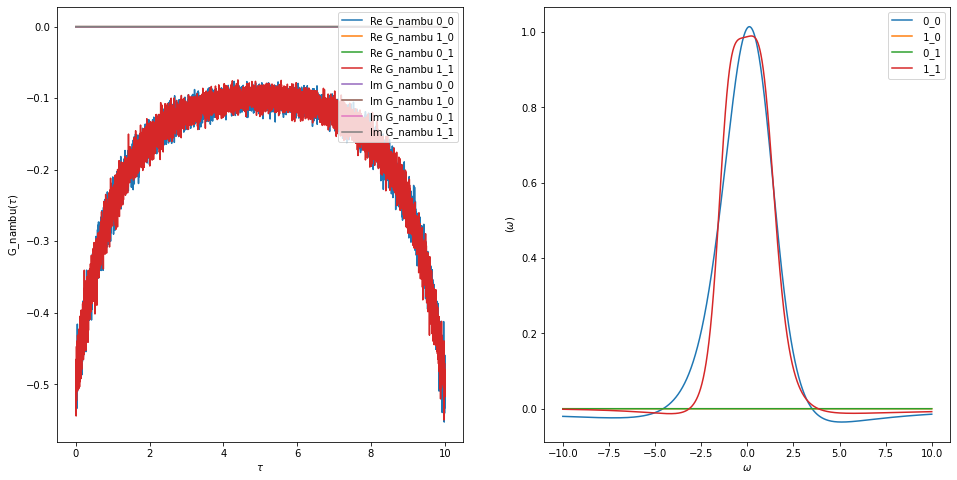

In [56]:
den = [S.G_iw['nambu'].density()[0, 0]]
print("New density: ", den)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].oplot(S.G_tau["nambu"])

g_real = GfReFreq(indices=[0, 1], window=(-10, 10))
g_real.set_from_pade(S.G_iw['nambu'], 100, 0.01)
ax[1].oplot(-g_real.imag)

(4.075901837810311e-21+1.2164024214402418e-22j)
(4.075901837810311e-21-1.2164024214402418e-22j)
(4.075901837810311e-21+1.2164024214402418e-22j)
(4.075901837810311e-21-1.2164024214402418e-22j)


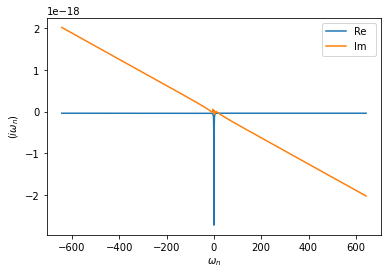

In [16]:
oplot(Sigma[1, 0])
# oplot(S.G_iw["nambu"][0,0])
print(S.G_iw['nambu'][0, 1](0))
print(S.G_iw['nambu'][0, 1](-1))
print(S.G_iw['nambu'][1, 0](0))
print(S.G_iw['nambu'][1, 0](-1))

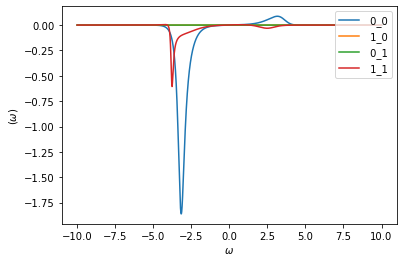

In [5]:
g_real = GfReFreq(indices=[0, 0], window=(-10, 10))
g_real.set_from_pade(S.G_iw["nambu"])
oplot(-g_real.imag/np.pi)